# Partitioning Illinois to find best locations to build a For-Profit Hospital

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
path = "./Medicare-Physician-and-Other-Supplier-PUF/Medicare_Provider_Util_Payment_PUF_CY2016.txt"
data = pd.read_csv(path,sep='\t',low_memory=False)

Previewing original dataset:

In [5]:
pd.set_option('display.max_columns', 0)
data.head()

,NPI,NPPES_PROVIDER_LAST_ORG_NAME,NPPES_PROVIDER_FIRST_NAME,NPPES_PROVIDER_MI,NPPES_CREDENTIALS,NPPES_PROVIDER_GENDER,NPPES_ENTITY_CODE,NPPES_PROVIDER_STREET1,NPPES_PROVIDER_STREET2,NPPES_PROVIDER_CITY,NPPES_PROVIDER_ZIP,NPPES_PROVIDER_STATE,NPPES_PROVIDER_COUNTRY,PROVIDER_TYPE,MEDICARE_PARTICIPATION_INDICATOR,PLACE_OF_SERVICE,HCPCS_CODE,HCPCS_DESCRIPTION,HCPCS_DRUG_INDICATOR,LINE_SRVC_CNT,BENE_UNIQUE_CNT,BENE_DAY_SRVC_CNT,AVERAGE_MEDICARE_ALLOWED_AMT,AVERAGE_SUBMITTED_CHRG_AMT,AVERAGE_MEDICARE_PAYMENT_AMT,AVERAGE_MEDICARE_STANDARD_AMT
0,1,CPT copyright 2015 American Medical Associatio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,215021854,MD,US,Internal Medicine,Y,F,99217,Hospital observation care discharge,N,57.0,55.0,57.0,72.743158,325.157895,54.474386,55.807193
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,215021854,MD,US,Internal Medicine,Y,F,99219,Hospital observation care typically 50 minutes,N,38.0,38.0,38.0,135.010000,614.000000,105.850000,107.230000
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,215021854,MD,US,Internal Medicine,Y,F,99220,Hospital observation care typically 70 minutes...,N,23.0,23.0,23.0,189.239565,769.347826,146.116522,144.278696
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,215021854,MD,US,Internal Medicine,Y,F,99221,"Initial hospital inpatient care, typically 30 ...",N,20.0,20.0,20.0,100.750000,460.000000,78.990000,80.280000


Looking at only Illinois data:

In [3]:
illinois_data = data.loc[data['NPPES_PROVIDER_STATE'] == 'IL']

Looking at only the providers that accept Medicare as payment:

In [4]:
illinois_data = illinois_data.loc[illinois_data['MEDICARE_PARTICIPATION_INDICATOR'] == 'Y']

The 'NPPES_PROVIDER_STATE' column is dropped since every value is 'IL' now.
'NPPES_PROVIDER_COUNTRY' column is dropped since every value is 'US'.

'MEDICARE_PARTICIPATION_INDICATOR' column is dropped since every value is 'Y' now.

Also manually dropping columns that have no relevance to business question:

'NPI','NPPES_PROVIDER_LAST_ORG_NAME','NPPES_PROVIDER_FIRST_NAME','NPPES_PROVIDER_MI','NPPES_CREDENTIALS','NPPES_PROVIDER_GENDER','NPPES_PROVIDER_STREET1','NPPES_PROVIDER_STREET2','NPPES_PROVIDER_STREET1','NPPES_PROVIDER_STREET2' - name and identifiers of provider does not matter

'NPPES_PROVIDER_CITY' - using 3 digit zip as better metric for location

'NPPES_ENTITY_CODE','PROVIDER_TYPE','PLACE_OF_SERVICE' - does not matter as we are focused on costs and payments

'HCPCS_CODE','HCPCS_DESCRIPTION','HCPCS_DRUG_INDICATOR' - HCPCS code does not matter in deciding where to build a hospital based on costs and payments

In [5]:
illinois_data = illinois_data.drop(columns=['NPI', 'NPPES_PROVIDER_LAST_ORG_NAME','NPPES_PROVIDER_FIRST_NAME','NPPES_PROVIDER_MI','NPPES_CREDENTIALS','NPPES_PROVIDER_GENDER','NPPES_ENTITY_CODE','NPPES_PROVIDER_STREET1','NPPES_PROVIDER_STREET2','NPPES_PROVIDER_CITY','NPPES_PROVIDER_STATE','NPPES_PROVIDER_COUNTRY','PROVIDER_TYPE','MEDICARE_PARTICIPATION_INDICATOR','PLACE_OF_SERVICE','HCPCS_CODE','HCPCS_DESCRIPTION','HCPCS_DRUG_INDICATOR'])

Cutting down zip code to first 3 digits:

In [6]:
illinois_data.NPPES_PROVIDER_ZIP = illinois_data.NPPES_PROVIDER_ZIP.str[:3]

Looking at multicollinearity and removing features that are highly correlated:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ab34f27f0>,
      dtype=object)

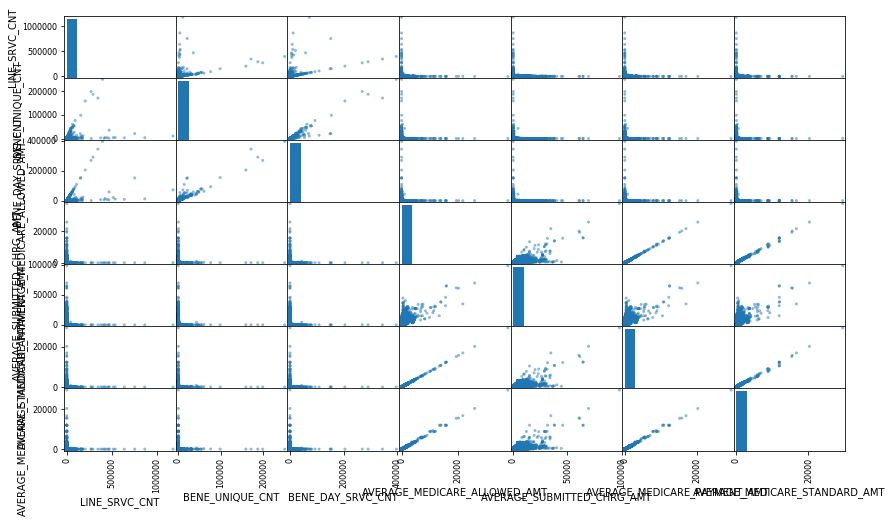

In [301]:
pd.plotting.scatter_matrix(illinois_data,figsize=(14,8))

In [302]:
illinois_data.corr()

,LINE_SRVC_CNT,BENE_UNIQUE_CNT,BENE_DAY_SRVC_CNT,AVERAGE_MEDICARE_ALLOWED_AMT,AVERAGE_SUBMITTED_CHRG_AMT,AVERAGE_MEDICARE_PAYMENT_AMT,AVERAGE_MEDICARE_STANDARD_AMT
LINE_SRVC_CNT,1.000000,0.364902,0.458561,-0.014412,-0.013478,-0.014199,-0.013961
BENE_UNIQUE_CNT,0.364902,1.000000,0.945993,-0.010431,-0.012063,-0.010333,-0.010088
BENE_DAY_SRVC_CNT,0.458561,0.945993,1.000000,-0.013585,-0.016074,-0.013565,-0.013200
AVERAGE_MEDICARE_ALLOWED_AMT,-0.014412,-0.010431,-0.013585,1.000000,0.759006,0.998709,0.996288
AVERAGE_SUBMITTED_CHRG_AMT,-0.013478,-0.012063,-0.016074,0.759006,1.000000,0.758804,0.745292
AVERAGE_MEDICARE_PAYMENT_AMT,-0.014199,-0.010333,-0.013565,0.998709,0.758804,1.000000,0.996854
AVERAGE_MEDICARE_STANDARD_AMT,-0.013961,-0.010088,-0.013200,0.996288,0.745292,0.996854,1.000000


'BENE_UNIQUE_CNT' has high correlation with 'BENE_DAY_SRVC_CNT'. 'BENE_DAY_SRVC_CNT' is kept since it removes double-counting of the similar services on the same day as well as describes the daily rates of service and not simply the total count.

Because the features "AVERAGE_MEDICARE_ALLOWED_AMT", "AVERAGE_MEDICARE_PAYMENT_AMT", and "AVERAGE_MEDICARE_STANDARD_AMT" have high correlations, two of these features can be removed. 

"AVERAGE_MEDICARE_STANDARD_AMT" is simply the standardized data of "AVERAGE_MEDICARE_PAYMENT_AMT" with geographical differences in payment rates removed. 

Both features "AVERAGE_MEDICARE_PAYMENT_AMT" and "AVERAGE_MEDICARE_STANDARD_AMT" don't include what the beneficiary is paying for and are thus removed. The feature "AVERAGE_MEDICARE_ALLOWED_AMT" is kept to explore what Medicare pays, including deductible and coinsurance amounts that the beneficiary is responsible for paying.

In [7]:
illinois_data = illinois_data.drop(columns=['BENE_UNIQUE_CNT','AVERAGE_MEDICARE_STANDARD_AMT','AVERAGE_MEDICARE_PAYMENT_AMT'])

Histogram of numerical features:

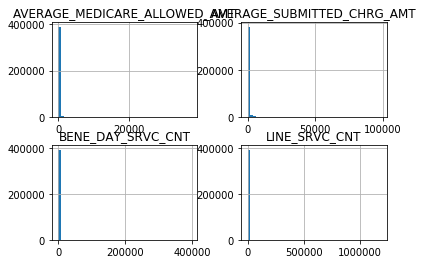

In [8]:
hist = illinois_data.hist(bins=50)

Log transforming data:

In [8]:
illinois_data['LINE_SRVC_CNT'] = np.log(illinois_data['LINE_SRVC_CNT'])
illinois_data['BENE_DAY_SRVC_CNT'] = np.log(illinois_data['BENE_DAY_SRVC_CNT'])
illinois_data['AVERAGE_SUBMITTED_CHRG_AMT'] = np.log(illinois_data['AVERAGE_SUBMITTED_CHRG_AMT'])
illinois_data['AVERAGE_MEDICARE_ALLOWED_AMT'] = np.log(illinois_data['AVERAGE_MEDICARE_ALLOWED_AMT'])

After log transformation, some features which had a skewed distribution became more normally distributed and are more spread out.

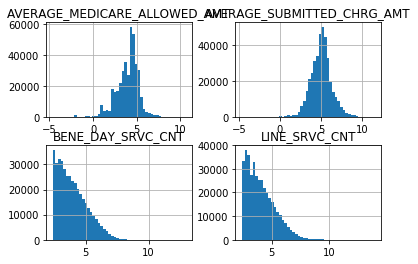

In [10]:
hist = illinois_data.hist(bins=50)

One hot encoding:

In [9]:
# categorical features
cat_features = ['NPPES_PROVIDER_ZIP']
df_processed = pd.get_dummies(illinois_data, prefix_sep="__",columns=cat_features)

In [12]:
df_processed.head()

,LINE_SRVC_CNT,BENE_DAY_SRVC_CNT,AVERAGE_MEDICARE_ALLOWED_AMT,AVERAGE_SUBMITTED_CHRG_AMT,NPPES_PROVIDER_ZIP__006,NPPES_PROVIDER_ZIP__061,NPPES_PROVIDER_ZIP__104,NPPES_PROVIDER_ZIP__322,NPPES_PROVIDER_ZIP__461,NPPES_PROVIDER_ZIP__463,...,NPPES_PROVIDER_ZIP__625,NPPES_PROVIDER_ZIP__626,NPPES_PROVIDER_ZIP__627,NPPES_PROVIDER_ZIP__628,NPPES_PROVIDER_ZIP__629,NPPES_PROVIDER_ZIP__631,NPPES_PROVIDER_ZIP__640,NPPES_PROVIDER_ZIP__681,NPPES_PROVIDER_ZIP__717,NPPES_PROVIDER_ZIP__900
13,5.389072,5.267858,2.520917,4.744932,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,8.829812,8.495356,3.722066,5.135798,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,6.042633,5.645447,3.376876,4.477337,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,4.158883,4.025352,2.577942,4.219508,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,3.583519,3.583519,4.527749,5.609472,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393123 entries, 13 to 9714490
Data columns (total 49 columns):
LINE_SRVC_CNT                   393123 non-null float64
BENE_DAY_SRVC_CNT               393123 non-null float64
AVERAGE_MEDICARE_ALLOWED_AMT    393123 non-null float64
AVERAGE_SUBMITTED_CHRG_AMT      393123 non-null float64
NPPES_PROVIDER_ZIP__006         393123 non-null uint8
NPPES_PROVIDER_ZIP__061         393123 non-null uint8
NPPES_PROVIDER_ZIP__104         393123 non-null uint8
NPPES_PROVIDER_ZIP__322         393123 non-null uint8
NPPES_PROVIDER_ZIP__461         393123 non-null uint8
NPPES_PROVIDER_ZIP__463         393123 non-null uint8
NPPES_PROVIDER_ZIP__465         393123 non-null uint8
NPPES_PROVIDER_ZIP__472         393123 non-null uint8
NPPES_PROVIDER_ZIP__501         393123 non-null uint8
NPPES_PROVIDER_ZIP__512         393123 non-null uint8
NPPES_PROVIDER_ZIP__523         393123 non-null uint8
NPPES_PROVIDER_ZIP__600         393123 non-null uint8
NPPES_PROVIDER_

Normalizing:

In [10]:
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(df_processed),columns = df_processed.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
df_scaled.head()

,LINE_SRVC_CNT,BENE_DAY_SRVC_CNT,AVERAGE_MEDICARE_ALLOWED_AMT,AVERAGE_SUBMITTED_CHRG_AMT,NPPES_PROVIDER_ZIP__006,NPPES_PROVIDER_ZIP__061,NPPES_PROVIDER_ZIP__104,NPPES_PROVIDER_ZIP__322,NPPES_PROVIDER_ZIP__461,NPPES_PROVIDER_ZIP__463,...,NPPES_PROVIDER_ZIP__625,NPPES_PROVIDER_ZIP__626,NPPES_PROVIDER_ZIP__627,NPPES_PROVIDER_ZIP__628,NPPES_PROVIDER_ZIP__629,NPPES_PROVIDER_ZIP__631,NPPES_PROVIDER_ZIP__640,NPPES_PROVIDER_ZIP__681,NPPES_PROVIDER_ZIP__717,NPPES_PROVIDER_ZIP__900
0,1.055026,1.100539,-1.136739,-0.223866,-0.005525,-0.004511,-0.002762,-0.003907,-0.00319,-0.00422,...,-0.118336,-0.057756,-0.209759,-0.106183,-0.127186,-0.00422,-0.002762,-0.005968,-0.004511,-0.002256
1,3.782908,3.850955,-0.179990,0.084118,-0.005525,-0.004511,-0.002762,-0.003907,-0.00319,-0.00422,...,-0.118336,-0.057756,-0.209759,-0.106183,-0.127186,-0.00422,-0.002762,-0.005968,-0.004511,-0.002256
2,1.573182,1.422313,-0.454944,-0.434719,-0.005525,-0.004511,-0.002762,-0.003907,-0.00319,-0.00422,...,-0.118336,-0.057756,-0.209759,-0.106183,-0.127186,-0.00422,-0.002762,-0.005968,-0.004511,-0.002256
3,0.079710,0.041697,-1.091318,-0.637877,-0.005525,-0.004511,-0.002762,-0.003907,-0.00319,-0.00422,...,-0.118336,-0.057756,-0.209759,-0.106183,-0.127186,-0.00422,-0.002762,-0.005968,-0.004511,-0.002256
4,-0.376449,-0.334825,0.461759,0.457351,-0.005525,-0.004511,-0.002762,-0.003907,-0.00319,-0.00422,...,-0.118336,-0.057756,-0.209759,-0.106183,-0.127186,-0.00422,-0.002762,-0.005968,-0.004511,-0.002256


# Main features for clustering:

NPPES_PROVIDER_ZIP - zip code (location)

LINE_SRVC_CNT - number of services (to see how the new hospital would compare)

BENE_DAY_SRVC_CNT - services per day (how much business a certain organization is getting)

AVERAGE_MEDICARE_ALLOWED_AMT - how much medicare pays including deductible and coinsurance

AVERAGE_SUBMITTED_CHRG_AMT - how much provider charges

Clustering:

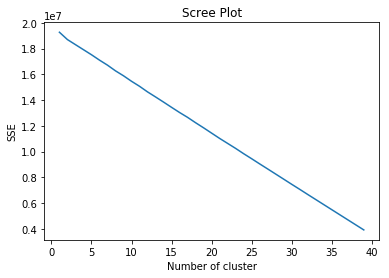

In [17]:
sse_test = {}
for k in range(1, 40):
    kmeans_test = KMeans(n_clusters=k, max_iter=300).fit(df_scaled)
    #df_scaled["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse_test[k] = kmeans_test.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse_test.keys()), list(sse_test.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("Scree Plot")
plt.show()

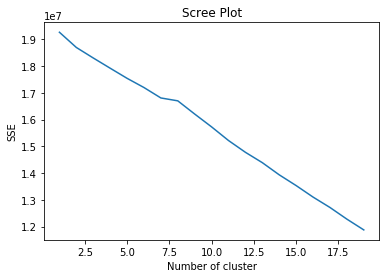

In [312]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=300).fit(df_scaled)
    #df_scaled["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("Scree Plot")
plt.show()

It seems as if the 'kink' in the scree plot is at number of clusters = 8. Numbers of clusters around 8 are explored further with silhouette scores:

In [313]:
clusters = [8,9,10,11]
centers = []
for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters,max_iter=1000)
    predictions = kmeans.fit_predict(df_scaled)
    centers.append(kmeans.cluster_centers_)
    score = silhouette_score(df_scaled,predictions,metric='euclidean')
    print('For n_clusters = ', n_clusters ,', silhouette score is ',score)

For n_clusters =  8 , silhouette score is  0.2986319610530669
For n_clusters =  9 , silhouette score is  0.2932941974630347
For n_clusters =  10 , silhouette score is  0.33883439746536675
For n_clusters =  11 , silhouette score is  0.34596988638480636


In [330]:
kmeans11 = KMeans(n_clusters=11,max_iter=1000)
predictions11 = kmeans11.fit_predict(df_scaled)
center = kmeans11.cluster_centers_

Looking at centers:

In [348]:
np.shape(center)

(11, 49)

In [341]:
center

array([[ 1.24058799e-02,  2.43370779e-02,  4.15403115e-02,
         3.27355300e-02, -5.52500945e-03, -4.51112837e-03,
        -2.76247310e-03, -3.90674183e-03, -3.18983323e-03,
        -4.21976883e-03, -4.21976883e-03, -9.83215152e-03,
        -6.17717192e-03, -4.78478028e-03, -3.90674183e-03,
        -4.21024585e-01,  2.72811988e+00, -1.30783239e-01,
        -8.36701357e-02, -3.48381293e-01, -3.20084498e-01,
        -4.80859404e-01, -8.28803695e-02, -9.04482870e-02,
        -1.04367736e-01, -1.06391325e-01, -1.66924877e-01,
        -1.30924015e-01, -8.84692055e-02, -8.26310870e-02,
        -7.25788774e-02, -1.83365728e-01, -1.33503413e-01,
        -1.50021023e-01, -8.03857581e-02, -1.19807790e-01,
        -1.51652747e-01, -9.80312439e-02, -7.92723675e-02,
        -1.18335590e-01, -5.77559472e-02, -2.09759111e-01,
        -1.06183276e-01, -1.27185634e-01, -4.21976883e-03,
        -2.76247310e-03, -5.96770744e-03, -4.51112837e-03,
        -2.25554697e-03],
       [ 4.79141555e-02,  5.70

Seeing which cluster centroids have the highest values for each numerical feature:

In [343]:
#[0] = LINE_SRVC_CNT
#[1] = BENE_DAY_SRVC_CNT
#[2] = AVERAGE_MEDICARE_ALLOWED_AMT
#[3] = AVERAGE_SUBMITTED_CHRG_AMT
#[4-48] = zip codes

max_line = max(center, key=lambda x:x[0])
max_bene =  max(center, key=lambda x:x[1])
max_medicare = max(center, key=lambda x:x[2])
max_submitted = max(center, key=lambda x:x[3])

In [351]:
np.argmax(max_line)
# index 15 corresponds to zip code 523
# df_scaled.columns()[np.argmax(max_line)] # returns 'NPPES_PROVIDER_ZIP__523'

15

In [352]:
np.argmax(max_bene)
# index 15 corresponds to zip code 523
# df_scaled.columns()[np.argmax(max_bene)] # returns 'NPPES_PROVIDER_ZIP__523'

15

In [353]:
np.argmax(max_medicare)
# index 17 corresponds to zip code 601
# df_scaled.columns()[np.argmax(max_medicare)] # returns 'NPPES_PROVIDER_ZIP__601'

17

In [354]:
np.argmax(max_submitted)
# index 21 corresponds to zip code 605
# df_scaled.columns()[np.argmax(max_submitted)] # returns 'NPPES_PROVIDER_ZIP__605'

21